In [1]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import seaborn.apionly as sns
import healpy as hp
from sklearn.model_selection import KFold
import dask
from dask import delayed, multiprocessing, compute
from dask.diagnostics import ProgressBar
import pyprind
from scipy.stats import chi2
from scipy.special import erfcinv

from icecube import astro

import comptools as comp
import comptools.analysis.plotting as plotting
import comptools.anisotropy.anisotropy as anisotropy

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
config = ['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']
years_str = '2011-2015'
composition='all'

n_side = 64
scale = 3
smooth = 0.0
n_bins = 36
decmax = -55
decmin = -90
low_energy = True

In [3]:
def get_proj_nbins_df(bins, data=None, ref=None, composition='all'):
    
    dipole_dict = defaultdict(list)
    for n_bins in bins:

        dipole_dict['n_bins'].append(n_bins)
        kwargs_relint_radius = {'config': config, 'low_energy': low_energy, 'smooth': smooth, 
                                'scale': None, 'decmax': decmax}
        if data is None:
            data = anisotropy.get_map(name='data', composition=composition, **kwargs_relint_radius)
        if ref is None:
            ref = anisotropy.get_map(name='ref', composition=composition, **kwargs_relint_radius)
#         relint_all = anisotropy.get_map(name='relint', composition='all', **kwargs_relint_radius)
#         relint_all_err = anisotropy.get_map(name='relerr', composition='all', **kwargs_relint_radius)
#         ri, ri_err, ra, ra_err = anisotropy.get_proj_relint(relint_all, relint_all_err, n_bins=n_bins)
        ri, ri_err, ra, ra_err = anisotropy.get_binned_relint(data, ref, n_bins=n_bins)
        
        n_dof = ri.shape[0]
        chi2_all = np.sum(ri**2 / ri_err**2)
        pval = chi2.sf(chi2_all, n_dof, loc=0, scale=1)
        sig = erfcinv(2*pval)*np.sqrt(2)

        dipole_dict['ri'].append(ri)
        dipole_dict['ri_err'].append(ri_err)
        dipole_dict['ra'].append(ra)
        dipole_dict['pval'].append(pval)
        dipole_dict['sig'].append(sig)

        
    return pd.DataFrame.from_records(dipole_dict, index='n_bins')

In [4]:
# proj_light_df = get_proj_nbins_df(bins, composition='light')
# proj_heavy_df = get_proj_nbins_df(bins, composition='heavy')

In [5]:
bins = np.arange(1, 72+1, 1, dtype=int)
proj_all_df = get_proj_nbins_df(bins, composition='all')
proj_light_df = get_proj_nbins_df(bins, composition='light')
proj_heavy_df = get_proj_nbins_df(bins, composition='heavy')

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


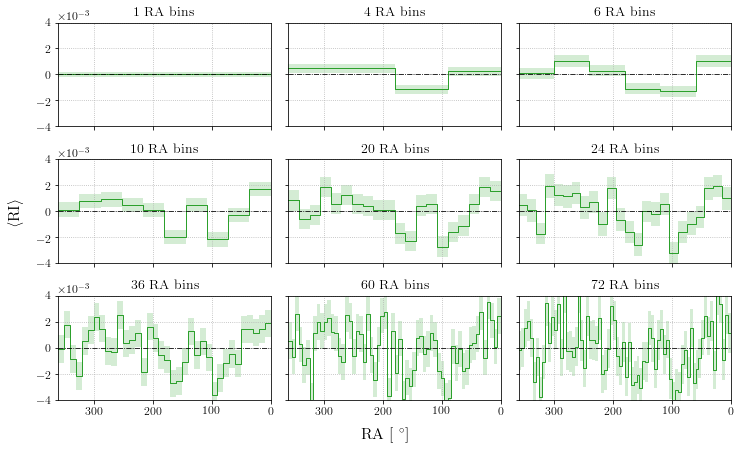

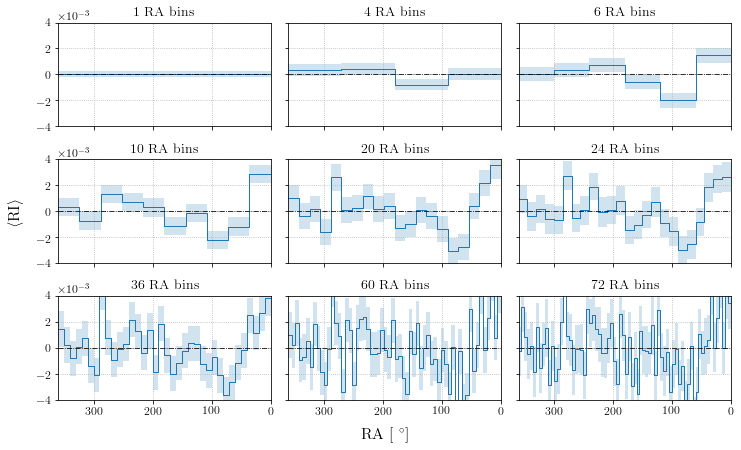

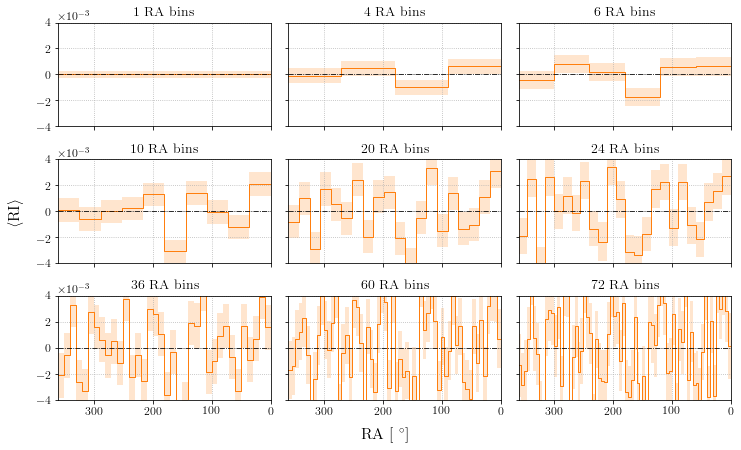

In [6]:
for proj_df, composition in zip([proj_all_df, proj_light_df, proj_heavy_df], ['total', 'light', 'heavy']):
    fig, axarr = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
    # for n_bins, ax in zip(proj_df.index[::10], axarr.flatten()):
    for n_bins, ax in zip([1, 4, 6, 10, 20, 24, 36, 60, 72], axarr.flatten()):
        proj_nbins = proj_df.loc[n_bins]

        ra_bins = np.linspace(0, 360, n_bins + 1)
        plotting.plot_steps(ra_bins, proj_nbins['ri'], yerr=proj_nbins['ri_err'],
                            color=color_dict[composition], label=composition, fillalpha=0.2,
                            ax=ax)
    #                         label='{}$\\sigma$'.format(proj_nbins['sig']), ax=ax)
        ax.axhline(0, marker='None', ls='-.', c='k')
        ax.set_title(str(n_bins)+' RA bins')
    #     ax.set_ylabel('$\mathrm{\langle RI \\rangle }$')
    #     ax.set_xlabel('RA [ $^{\circ}$]')
        ax.grid()
        ax.set_ylim(-4.0e-3, 4.0e-3)
        ax.set_xlim(0, 360)
        ax.invert_xaxis()
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    fig.text(0.5, -0.025, 'RA [ $^{\circ}$]', ha='center', fontsize=16)
    fig.text(-0.025, 0.5, '$\mathrm{\langle RI \\rangle }$', va='center', rotation='vertical', fontsize=16)

    plt.tight_layout()
    proj_vs_nbins_outfile = os.path.join(comp.paths.figures_dir,
                                          'anisotropy', 'proj_vs_nbins_{}.png'.format(composition))
    comp.check_output_dir(proj_vs_nbins_outfile)
    plt.savefig(proj_vs_nbins_outfile)
    plt.show()

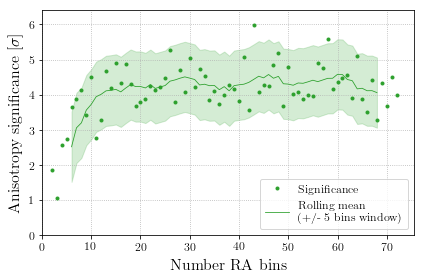

In [7]:
fig, ax = plt.subplots()
ax.plot(proj_all_df.index, proj_all_df['sig'], ls='None', label='Significance', color='C2')
ax.axhline(0, marker='None', ls='-.', color='k', lw=1)
rolling_mean = proj_all_df['sig'].rolling(window=10,center=True).mean()
ax.plot(rolling_mean.index, rolling_mean, marker='None', ls='-', color='C2', label='Rolling mean\n(+/- 5 bins window)')
ax.fill_between(rolling_mean.index, rolling_mean+1, rolling_mean-1, color='C2', alpha=0.2)
ax.set_xlabel('Number RA bins')
ax.set_ylabel('Anisotropy significance [$\\sigma$]')
ax.set_ylim(0)
ax.set_xlim(0)
ax.grid()
ax.legend()

sig_vs_nbins_outfile = os.path.join(comp.paths.figures_dir,
                                      'anisotropy', 'sig_vs_nbins_all.png')
comp.check_output_dir(sig_vs_nbins_outfile)
plt.savefig(sig_vs_nbins_outfile)
plt.show()

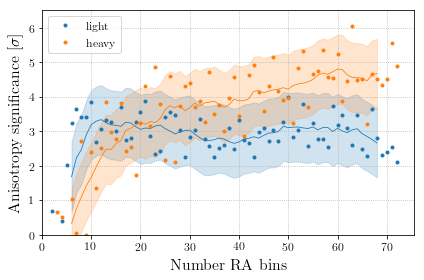

In [8]:
fig, ax = plt.subplots()
for proj_df, composition in zip([proj_light_df, proj_heavy_df], ['light', 'heavy']):
    ax.plot(proj_df.index, proj_df['sig'], ls='None', label=composition, color=color_dict[composition])
#     ax.axhline(0, marker='None', ls='-.', color='k', lw=1)
    rolling_mean = proj_df['sig'].rolling(window=10,center=True).mean()
    ax.plot(rolling_mean.index, rolling_mean, marker='None', ls='-', color=color_dict[composition], label='')
    ax.fill_between(rolling_mean.index, rolling_mean+1, rolling_mean-1, color=color_dict[composition], alpha=0.2, label='')
ax.set_xlabel('Number RA bins')
ax.set_ylabel('Anisotropy significance [$\\sigma$]')
ax.set_ylim(0)
ax.set_xlim(0)
ax.grid()
ax.legend()

sig_vs_nbins_outfile = os.path.join(comp.paths.figures_dir,
                                      'anisotropy', 'sig_vs_nbins_comp.png')
comp.check_output_dir(sig_vs_nbins_outfile)
plt.savefig(sig_vs_nbins_outfile)
plt.show()

The heavy projected relative intensities (for large number of RA bins) looks like fluxuations, but is still ~4-sigma away from the null hypothesis. That's weird.

Scramble data in right acension to see if this feature goes away...

In [7]:
kwargs_data = {'config': config, 'low_energy': low_energy, 'smooth': smooth, 
               'scale': None, 'decmax': decmax}
data_heavy = anisotropy.get_map(name='data', composition='heavy', **kwargs_data)
ref_heavy = anisotropy.get_map(name='ref', composition='heavy', **kwargs_data)

In [8]:
data_heavy

array([ -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30, ...,
         1.25810000e+04,   1.25830000e+04,   1.24530000e+04])

In [11]:
# Bin in declination
theta, phi = hp.pix2ang(n_side, range(len(data_heavy)))
thetamax =  np.deg2rad(90 - decmin)
thetamin = np.deg2rad(90 - decmax)
# dec_mask = (theta <= thetamax) & (theta >= thetamin)
n_dec_bins = 30
dec_bins= np.linspace(thetamin, thetamax, n_dec_bins+1, dtype=float)
theta_bin_num = np.digitize(theta, dec_bins) - 1

In [12]:
theta_bin_num

array([-1, -1, -1, ..., 29, 29, 29])

In [20]:
data_heavy_RAscrambled = data_heavy.copy()
for idx in range(n_dec_bins):
    theta_bin_mask = (theta_bin_num == idx)
    unseen_mask = data_heavy == hp.UNSEEN
    combined_mask = theta_bin_mask & ~unseen_mask
    
    data_in_dec_bin = data_heavy.copy()
    data_in_dec_bin = data_in_dec_bin[combined_mask]
    data_series = pd.Series(data_in_dec_bin)
    print(idx)
    shuffled_data = data_series.sample(frac=1.0, random_state=2).values
    data_heavy_RAscrambled[combined_mask] = shuffled_data
#     np.random.shuffle(data_in_dec_bin)
#     data_heavy_RAscrambled[combined_mask] = data_in_dec_bin

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [9]:
def get_noisy_proj_sig(composition, random_state):
    # Set random state for trials
    np.random.seed(random_state)
    
    kwargs_data = {'config': config, 'low_energy': low_energy, 'smooth': smooth, 
                   'scale': None, 'decmax': decmax}
    ref = anisotropy.get_map(name='ref', composition=composition, **kwargs_data)
    unseen_mask = ref == hp.UNSEEN
    ref_poisson_noise = ref.copy()
    ref_poisson_noise[~unseen_mask] = np.random.poisson(ref_poisson_noise[~unseen_mask])
    
    proj_df = get_proj_nbins_df(bins, data=ref_poisson_noise, ref=ref)
    
    return proj_df['sig']

In [10]:
n_noise_trials = 1000
sig_ref_noise = [delayed(get_noisy_proj_sig)('all', random_state) for random_state in range(n_noise_trials)]
sig_ref_noise = delayed(pd.concat)(sig_ref_noise)
# sig_ref_noise = sig_ref_noise.divide(n_noise_trials)

In [11]:
with ProgressBar():
#     sig_ref_noise = sig_ref_noise.compute(get=dask.get)
    sig_ref_noise = sig_ref_noise.compute(get=multiprocessing.get, num_works=25)

[########################################] | 100% Completed |  2min  8.5s


In [12]:
grouped_nbins = sig_ref_noise.groupby(sig_ref_noise.index)

In [13]:
def gaussian(x, mu=0, sigma=1):
    return np.exp(-(x - mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

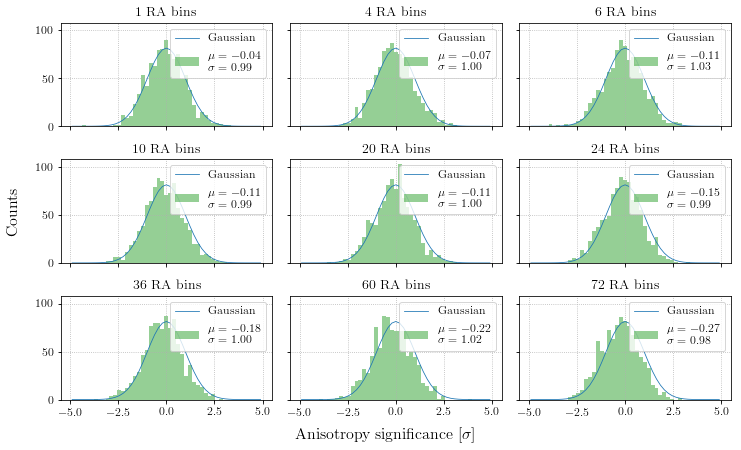

In [14]:
sig_bins, sig_step = np.linspace(-5, 5, 50, retstep=True)
sig_midpoints = (sig_bins[1:] + sig_bins[:-1]) / 2

fig, axarr = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
for n_bins, ax in zip([1, 4, 6, 10, 20, 24, 36, 60, 72], axarr.flatten()):
    df_noise_nbins = grouped_nbins.get_group(n_bins)
    
    label_mean = '$\mu = {:0.2f}$'.format(df_noise_nbins.mean())
    label_std = '$\sigma = {:0.2f}$'.format(df_noise_nbins.std())
    df_noise_nbins.plot(kind='hist', bins=sig_bins, histtype='stepfilled', alpha=0.5, lw=1.5, 
                        color=color_dict['total'], ax=ax, label=label_mean + '\n ' + label_std)
    
    ax.plot(sig_midpoints, n_noise_trials*sig_step*gaussian(sig_midpoints), 
            marker='None', label='Gaussian')
    
    ax.set_ylabel('')
    ax.set_title('{} RA bins'.format(n_bins))
    ax.grid()
    ax.legend()

fig.text(0.5, -0.025, 'Anisotropy significance [$\\sigma$]', ha='center', fontsize=16)
fig.text(-0.025, 0.5, 'Counts', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()

sig_vs_nbins_outfile = os.path.join(comp.paths.figures_dir,
                                      'anisotropy', 'sig_vs_nbins_all.png')
comp.check_output_dir(sig_vs_nbins_outfile)
plt.savefig(sig_vs_nbins_outfile)
plt.show()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


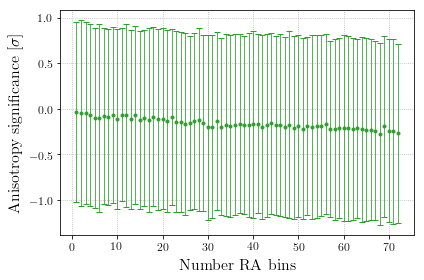

In [15]:
fig, ax = plt.subplots()
for n_bins in grouped_nbins.indices.keys():
    df_noise_nbins = grouped_nbins.get_group(n_bins)
    
#     label_mean = '$\mu = {:0.2f}$'.format(df_noise_nbins.mean())
#     label_std = '$\sigma = {:0.2f}$'.format(df_noise_nbins.std())
#     df_noise_nbins.plot(kind='hist', bins=sig_bins, histtype='stepfilled', alpha=0.5, lw=1.5, 
#                         color=color_dict['total'], ax=ax, label=label_mean + '\n ' + label_std)
    mean = df_noise_nbins.mean()
    err = df_noise_nbins.std()
    ax.errorbar(n_bins, mean, yerr=err, marker='.', color=color_dict['total'])
#     ax.fill_between(n_bins, mean-err, mean+err)
    
ax.set_ylabel('Anisotropy significance [$\\sigma$]')
ax.set_xlabel('Number RA bins')
ax.grid()
ax.legend()

# fig.text(0.5, -0.025, 'Anisotropy significance [$\\sigma$]', ha='center', fontsize=16)
# fig.text(-0.025, 0.5, 'Counts', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()

# sig_vs_nbins_outfile = os.path.join(comp.paths.figures_dir,
#                                       'anisotropy', 'sig_vs_nbins_all.png')
# comp.check_output_dir(sig_vs_nbins_outfile)
# plt.savefig(sig_vs_nbins_outfile)
plt.show()

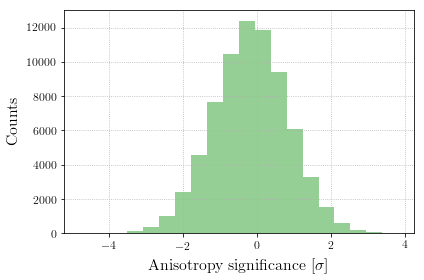

In [16]:
fig, ax = plt.subplots()
sig_ref_noise.plot(kind='hist', bins=20, histtype='stepfilled', alpha=0.5, lw=1.5, color=color_dict['total'], ax=ax)
ax.set_ylabel('Counts')
ax.set_xlabel('Anisotropy significance [$\\sigma$]')
ax.grid()
plt.show()

In [39]:
def get_RAscrambled_proj_sig(composition, random_state):

    kwargs_data = {'config': config, 'low_energy': low_energy, 'smooth': smooth, 
                   'scale': None, 'decmax': decmax, 'decmin': decmin}
    ref = anisotropy.get_map(name='ref', composition=composition, **kwargs_data)
    data = anisotropy.get_map(name='data', composition=composition, **kwargs_data)
    
    # Bin in declination
    theta, phi = hp.pix2ang(n_side, range(len(data)))
    thetamax =  np.deg2rad(90 - decmin)
    thetamin = np.deg2rad(90 - decmax)
    n_dec_bins = 20
    theta_bins= np.linspace(thetamin, thetamax, n_dec_bins+1)
    theta_bin_num = np.digitize(theta, theta_bins) - 1
    
    data_ra_scrambled = data.copy()
    unseen_mask = data_ra_scrambled == hp.UNSEEN
    for idx in range(n_dec_bins):
        theta_bin_mask = (theta_bin_num == idx)
        combined_mask = theta_bin_mask & ~unseen_mask

        data_in_dec_bin = data_ra_scrambled[combined_mask]
        shuffled_data = pd.Series(data_in_dec_bin).sample(frac=1.0, random_state=random_state).values
        data_ra_scrambled[combined_mask] = shuffled_data
        
    proj_df = get_proj_nbins_df(bins, data=data_ra_scrambled, ref=ref)
    
    return proj_df

In [40]:
n_ra_scramble_trials = 10
sig_ra_scambled = [delayed(get_RAscrambled_proj_sig)('light', random_state) 
                   for random_state in range(n_ra_scramble_trials)]
sig_ra_scambled = delayed(pd.concat)(sig_ra_scambled)

In [41]:
with ProgressBar():
    sig_ra_scambled = sig_ra_scambled.compute(get=multiprocessing.get, num_works=min(n_ra_scramble_trials, 25))

[########################################] | 100% Completed |  2.8s


In [42]:
sig_ra_scambled['ri']

n_bins
1                                  [-7.49955059482e-07]
2               [0.000780218708309, -0.000781942376933]
3     [0.00400626325896, -0.00589595082463, 0.001946...
4     [0.00546058037609, -0.00385492930699, -0.00547...
5     [0.00685726496341, -0.00248103583895, -0.00581...
6     [0.00807309214413, -3.49683432702e-05, -0.0056...
7     [0.00859965498805, 0.001976915122, -0.00502987...
8     [0.00780197478235, 0.00324920756906, -0.002506...
9     [0.00791606574932, 0.00282583455722, 0.0013146...
10    [0.00865072780184, 0.00508026612302, 0.0015671...
11    [0.00946829783759, 0.00583606843044, 0.0012165...
12    [0.00718168745959, 0.00896053892579, 0.0002608...
13    [0.00629649052751, 0.0113549317776, -0.0014310...
14    [0.0068663176058, 0.0103279310548, 8.332493503...
15    [0.00782822424604, 0.010406070393, 0.002320186...
16    [0.00556309239899, 0.0100284860197, 0.00778398...
17    [0.00609035354973, 0.00793341667925, 0.0097133...
18    [0.00717464419953, 0.00865327515507

In [43]:
grouped_nbins = sig_ra_scambled.groupby(sig_ra_scambled.index)

In [44]:
grouped_nbins.get_group(n_bins).ri.mean()

array([ 0.01239035,  0.00593411,  0.0059825 ,  0.0070139 , -0.00187172,
        0.00399862,  0.01083747,  0.00338297,  0.00842307,  0.00978682,
        0.00347163, -0.00364208,  0.0078841 , -0.00165306,  0.00320444,
       -0.00241502,  0.00685174, -0.00067593, -0.00196583,  0.0048254 ,
       -0.00537503, -0.00041326, -0.00809486,  0.00129093, -0.00330184,
       -0.00964921, -0.00236364, -0.00231528, -0.00290183, -0.00887491,
       -0.00113072, -0.01031647, -0.00721988, -0.01037523, -0.00089973,
       -0.00833854, -0.0118714 , -0.00310401, -0.0154536 , -0.00523185,
       -0.01689417, -0.00094065, -0.01278114, -0.00623046, -0.00027851,
       -0.00336318, -0.00188182, -0.00396765,  0.003084  , -0.012901  ,
        0.0024597 , -0.00350024,  0.00218983, -0.00371334, -0.0023842 ,
        0.00286985,  0.00096104,  0.00327281, -0.00261725,  0.00522117,
        0.00203846,  0.00175794,  0.01097639,  0.00866144,  0.00292367,
        0.00546086,  0.01425821,  0.00201709,  0.0056993 ,  0.01

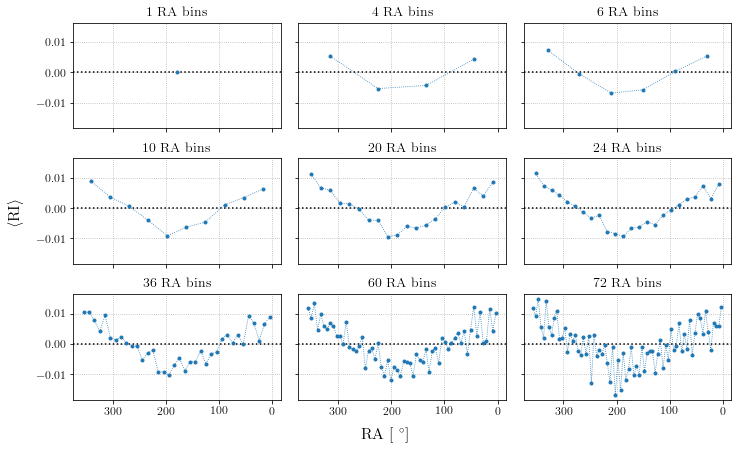

In [47]:
fig, axarr = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
for n_bins, ax in zip([1, 4, 6, 10, 20, 24, 36, 60, 72], axarr.flatten()):
    df_scambled_nbins = grouped_nbins.get_group(n_bins)
    ax.errorbar(df_scambled_nbins['ra'].mean(), df_scambled_nbins['ri'].mean(), 
                yerr=None, marker='.', ls=':')
    ax.axhline(0, marker='None', ls=':', color='k', lw=1.5)
    ax.set_title('{} RA bins'.format(n_bins))
    ax.grid()
ax.invert_xaxis()
fig.text(0.5, -0.025, 'RA [ $^{\circ}$]', ha='center', fontsize=16)
fig.text(-0.025, 0.5, '$\mathrm{\langle RI \\rangle }$', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.show()

In [166]:
# sig_ra_scambled.replace([np.inf, -np.inf], np.nan, inplace=True)

In [140]:
grouped_nbins = sig_ra_scambled.groupby(sig_ra_scambled.index)

n_bins
1   -2.628571
1   -2.628571
1   -2.628571
1   -2.628571
1   -2.628571
1   -2.628571
1   -2.628571
1   -2.628571
1   -2.628571
1   -2.628571
Name: sig, dtype: float64
n_bins
2    -0.328377
2     4.605197
2    17.632022
2     1.877160
2     1.649151
2    10.539982
2     6.965440
2     4.109491
2    -0.940397
2     6.502411
Name: sig, dtype: float64
n_bins
3    31.355061
3    30.371360
3    27.296457
3    21.824074
3    32.688847
3    18.372389
3          inf
3    11.488752
3          inf
3    34.141636
Name: sig, dtype: float64


ValueError: range parameter must be finite.

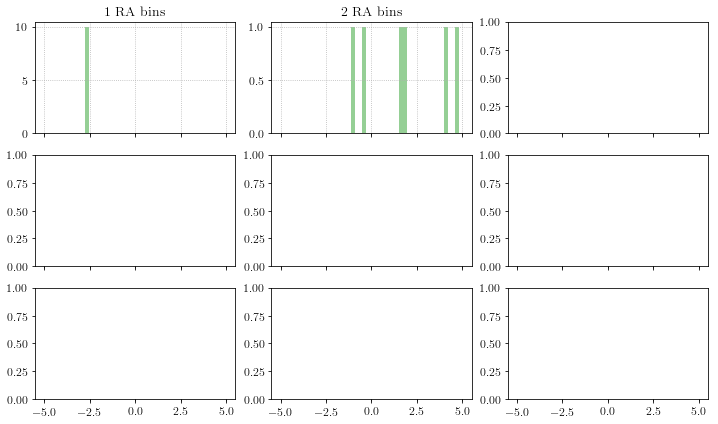

In [141]:
sig_bins, sig_step = np.linspace(-5, 5, 50, retstep=True)
sig_midpoints = (sig_bins[1:] + sig_bins[:-1]) / 2

fig, axarr = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=False)
for n_bins, ax in zip(range(1, 72), axarr.flatten()):
# for n_bins, ax in zip([1, 4, 6, 10, 20, 24, 36, 60, 72], axarr.flatten()):
    df_noise_nbins = grouped_nbins.get_group(n_bins)
    print(df_noise_nbins)
    
    label_mean = '$\mu = {:0.2f}$'.format(df_noise_nbins.mean())
    label_std = '$\sigma = {:0.2f}$'.format(df_noise_nbins.std())
    df_noise_nbins.plot(kind='hist', bins=sig_bins, histtype='stepfilled', alpha=0.5, lw=1.5, 
                        color=color_dict['total'], ax=ax, label=label_mean + '\n ' + label_std)
    
#     ax.plot(sig_midpoints, n_noise_trials*sig_step*gaussian(sig_midpoints), 
#             marker='None', label='Gaussian')
    
    ax.set_ylabel('')
    ax.set_title('{} RA bins'.format(n_bins))
    ax.grid()
#     ax.legend()

fig.text(0.5, -0.025, 'Anisotropy significance [$\\sigma$]', ha='center', fontsize=16)
fig.text(-0.025, 0.5, 'Counts', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()

# sig_vs_nbins_outfile = os.path.join(comp.paths.figures_dir,
#                                       'anisotropy', 'sig_vs_nbins_all.png')
# comp.check_output_dir(sig_vs_nbins_outfile)
# plt.savefig(sig_vs_nbins_outfile)
plt.show()